In [1]:
!pip install "opencv-python-headless<4.3"
!pip install cellpose
!pip install stardist


In [2]:
!nvcc --version
!nvidia-smi

import os, shutil
import numpy as np
import matplotlib.pyplot as plt
from cellpose import core, utils, io, models, metrics
from glob import glob

use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')

zsh:1: command not found: nvcc
zsh:1: command not found: nvidia-smi
>>> GPU activated? NO


In [ ]:
# from tifffile import imread

# def load_splice(mask, input):
#     X = list(glob(mask+'/*.tif'))
#     Y = list(glob(input+'/*.tif'))

#     X = list(map(imread,X))
#     Y = list(map(imread,Y))

#     X = slice_numpy_array_list(X)
#     Y = slice_numpy_array_list(Y)
#     return X, Y



# def slice_numpy_array_list(array_list):
#     sliced_arrays = []

#     for image_array in array_list:
#         height, width = image_array.shape

#         crop_size = 144
#         stride = crop_size

#         for row in range(0, height, stride):
#             for col in range(0, width, stride):
#                 upper = row
#                 left = col
#                 lower = min(row + crop_size, height)
#                 right = min(col + crop_size, width)

#                 subarray = image_array[upper:lower, left:right]
#                 subarray_height, subarray_width = subarray.shape

#                 if subarray_height == crop_size and subarray_width == crop_size:
#                     # Only append if the subarray is exactly 144x144
#                     sliced_arrays.append(subarray)

#     return sliced_arrays


In [18]:
from cellpose import io

#X, Y = load_splice("/content/drive/MyDrive/MLP2/masks", "/content/drive/MyDrive/MLP2/inputs")
dir = "MLP2/cp_validate_mip"
files = io.get_image_files(dir, '_mask')
print(files)
images = [io.imread(f) for f in files]
maskdir = "MLP2/cp_validate_mip_masks"
gtfiles = io.get_image_files(maskdir, '')
print(gtfiles)
gt = [io.imread(m) for m in gtfiles]

#here is where you load each model
model_path = "MLP2/traindataHIL_mip/models/CP_final_mip"


model = models.CellposeModel(gpu=True, pretrained_model=model_path)


#we can probably finetune here too

flow_threshold = 0.4
cellprob_threshold = 0

diameter = model.diam_labels
print(diameter)

#running model on our images

masks, flows, styles = model.eval(images,
                                  channels = [0,0], #grayscale
                                  diameter = diameter,
                                  flow_threshold= flow_threshold,
                                  cellprob_threshold=cellprob_threshold)


print(masks)
print(len(masks))
print(len(gt))

['MLP2/cp_validate_mip/mip_0_0.tif', 'MLP2/cp_validate_mip/mip_0_400.tif', 'MLP2/cp_validate_mip/mip_400_0.tif', 'MLP2/cp_validate_mip/mip_400_400.tif', 'MLP2/cp_validate_mip/mip_800_0.tif', 'MLP2/cp_validate_mip/mip_800_400.tif']
['MLP2/cp_validate_mip_masks/mip_0_0_mask.tif', 'MLP2/cp_validate_mip_masks/mip_0_400_mask.tif', 'MLP2/cp_validate_mip_masks/mip_400_0_mask.tif', 'MLP2/cp_validate_mip_masks/mip_400_400_mask.tif', 'MLP2/cp_validate_mip_masks/mip_800_0_mask.tif', 'MLP2/cp_validate_mip_masks/mip_800_400_mask.tif']
23.658726
[array([[0, 0, 0, ..., 3, 0, 0],
       [0, 0, 0, ..., 3, 3, 0],
       [0, 0, 0, ..., 3, 3, 3],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16), array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   5,   5, ...,   0,   0,   0],
       [  0,   5,   5, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ..., 283, 283, 283],
       [  0,   0,   0, ..., 283, 283, 283],
       [ 

In [23]:
##TODO IS WHERE I NORMALIZE MY MASKS, NORMALIZED MASK ARE IN normalized_masks
from cellpose import transforms
normalized_masks = []

for mask in masks:
    n_m = mask
    n_m[n_m>0] = 255
    normalized_masks.append(n_m)

print(len(masks))
print(len(normalized_masks))

6
6


In [25]:
#TODO HERE IM USING MATCHING DATASET WITH THE NORMALIZED MASKS 
# attempt at using matching dataset from stardist..
# metrics dont look that great but maybe they are true :(
from stardist.matching import matching, matching_dataset
from tqdm import tqdm

taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(gt[3], normalized_masks[3], thresh=t, show_progress=False) for t in tqdm(taus)] # we can also compare with the augmentated image
stats[taus.index(0.7)]

100%|██████████| 9/9 [00:00<00:00, 17.25it/s]


DatasetMatching(criterion='iou', thresh=0.7, fp=137, tp=263, fn=137, precision=0.6575, recall=0.6575, accuracy=0.4897579143389199, f1=0.6575, n_true=400, n_pred=400, mean_true_score=0.5141829824447632, mean_matched_score=0.7820273497258755, panoptic_quality=0.5141829824447632, by_image=False)

In [ ]:
#this saves the predicted masks into _seg.npy files
io.masks_flows_to_seg(images,
                      masks,
                      flows,
                      diameter*np.ones(len(masks)),
                      files,
                      [0, 0])

In [ ]:
#I can also save it as png, and tif
io.save_masks(images,
              masks,
              flows,
              files,
              channels=[0, 0],
              png=True, # save masks as PNGs and save example image
              tif=True, # save masks as TIFFs
              save_txt=False, # save txt outlines for ImageJ
              save_flows=False, # save flows as TIFFs
              save_outlines=False, # save outlines as TIFFs
              )

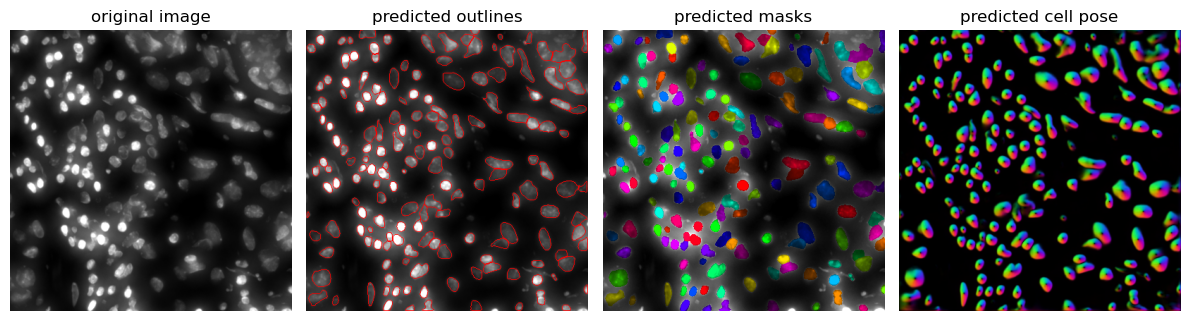

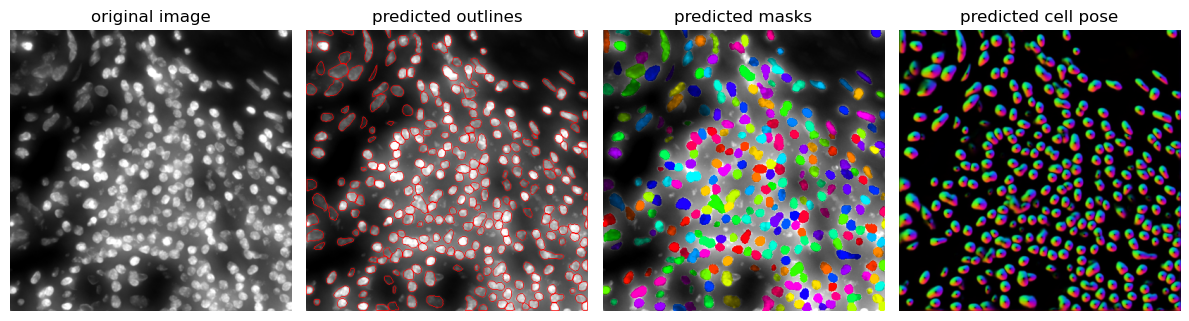

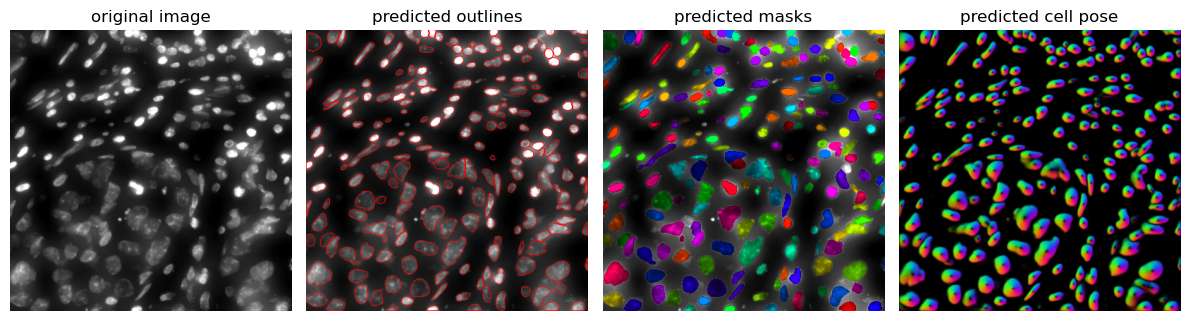

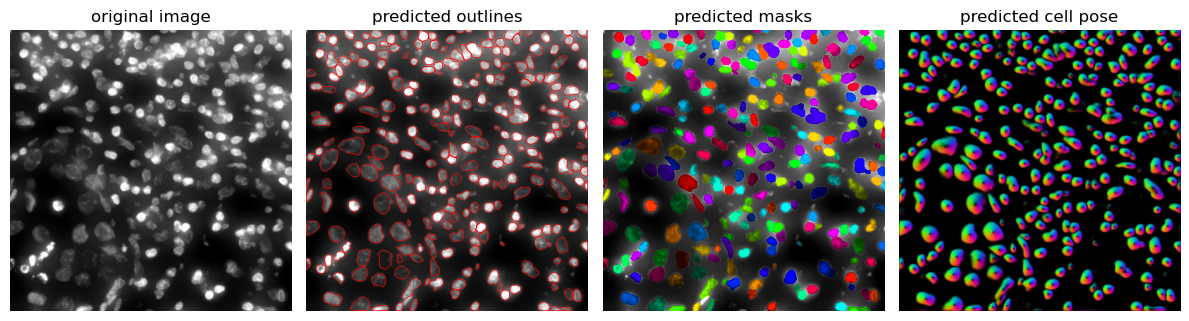

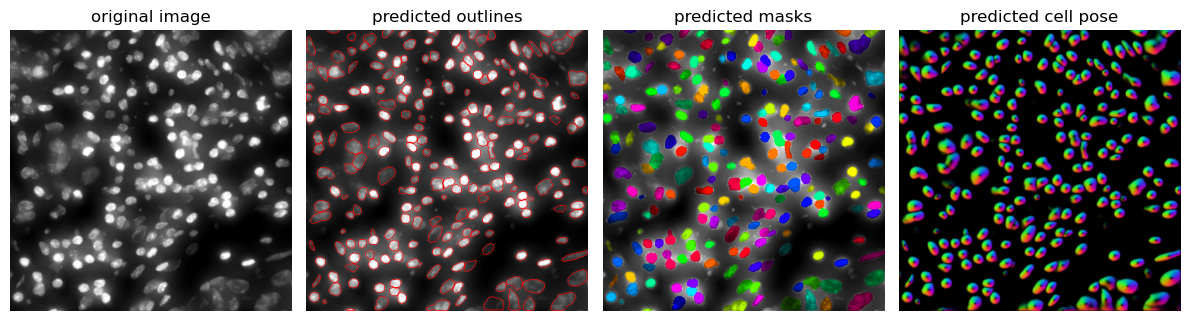

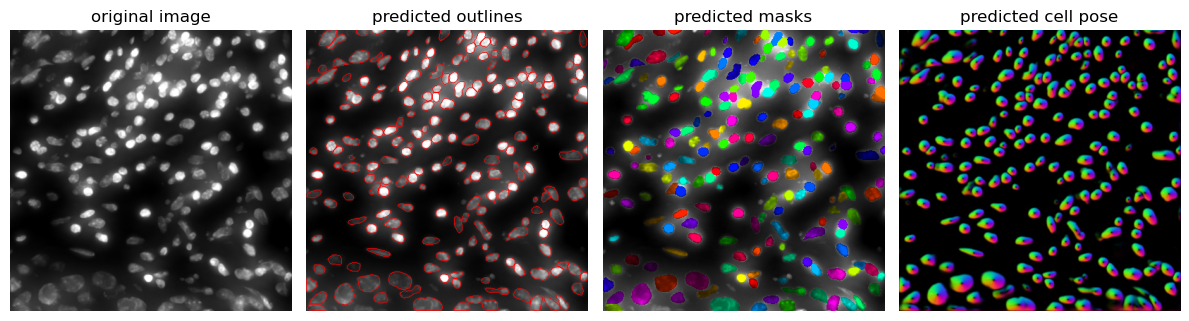

In [12]:
from cellpose import plot

nimg = len(images)
for idx in range(nimg):
    maski = masks[idx]
    flowi = flows[idx][0]

    fig = plt.figure(figsize=(12,5))
    plot.show_segmentation(fig, images[idx], maski, flowi)
    plt.tight_layout()
    plt.show()

In [27]:
def display_masks(ground_truth, predicted_mask):


    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Display the ground truth mask
    axes[0].imshow(ground_truth, cmap='gray')
    axes[0].set_title('Ground Truth Mask')

    # Display the predicted mask
    axes[1].imshow(predicted_mask, cmap='gray')
    axes[1].set_title('Predicted Mask')

    # Adjust layout and display the figure
    plt.tight_layout()
    plt.show()

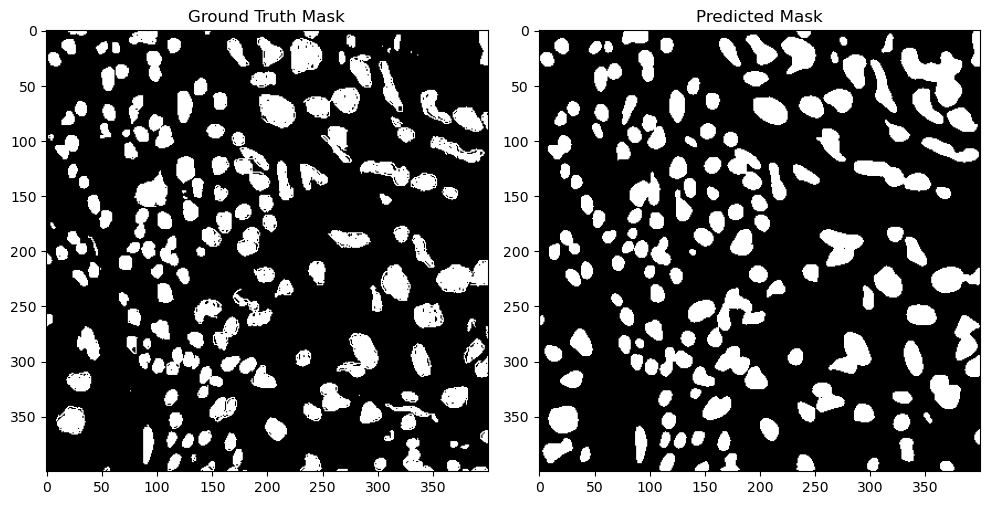

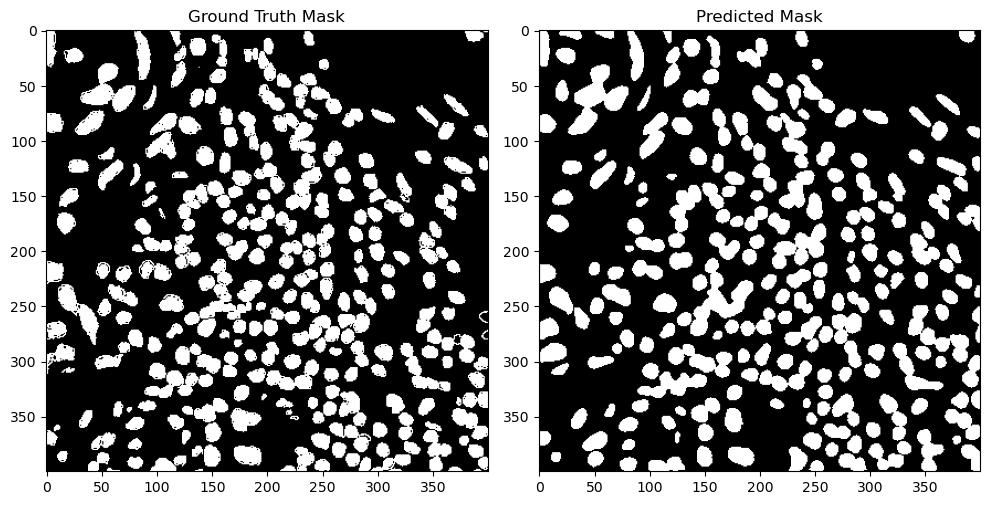

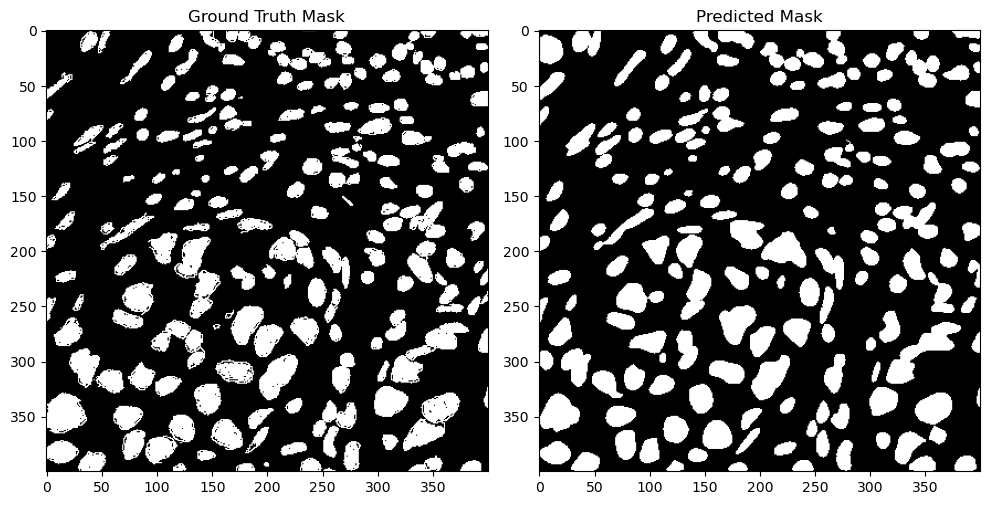

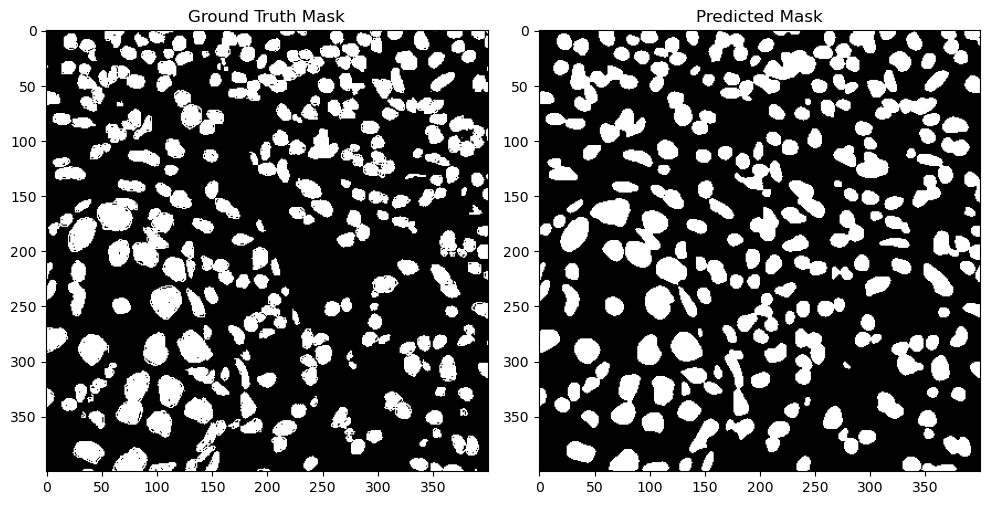

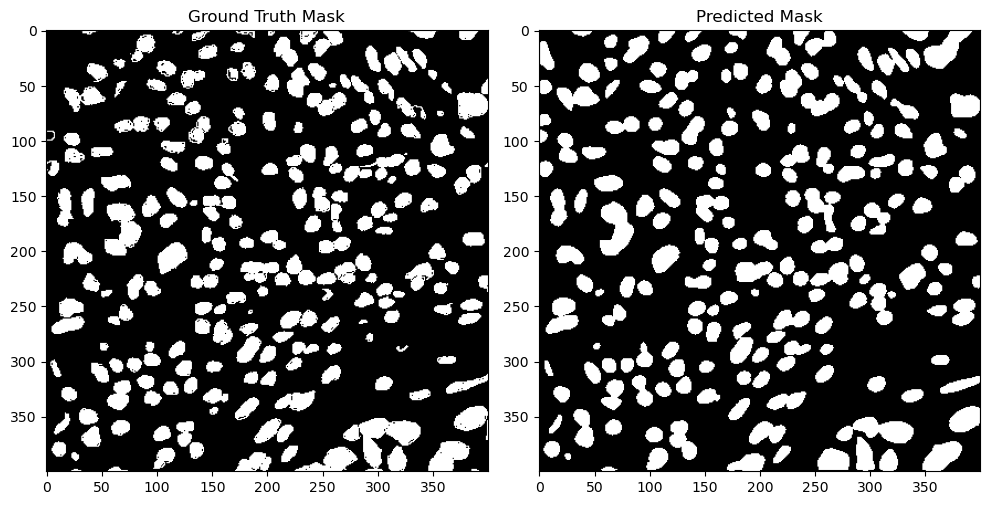

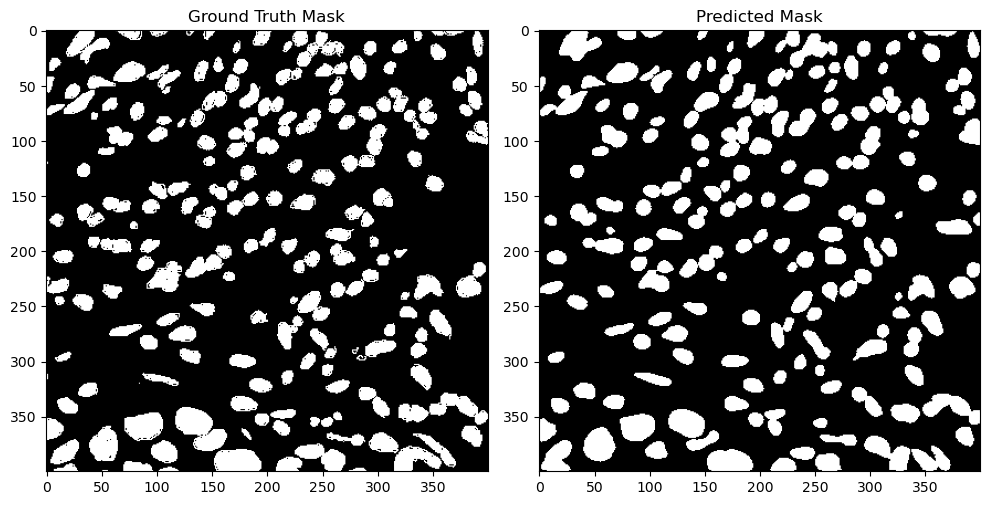

In [29]:
for i, img in enumerate(gt):
  display_masks(img, normalized_masks[i])



In [32]:
from cellpose import metrics
import matplotlib.pyplot as plt

#IM trying to conpute some useful metrics for my segmentation...

t = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]


ap, tp, fp, fn = metrics.average_precision(gt, normalized_masks, 0.5)
print( ap)
print( tp)
print( fp)
print( fn)

# # Plot average precision and recall with thresholds on the x-axis
# def plot_precision_recall_curve(ap, threshold):
#     plt.figure(figsize=(8, 6))
#     for i in range(len(ap)):
#         plt.plot(threshold, ap[i], label=f'Mask {i + 1}')

#     plt.title('Average Precision vs Threshold')
#     plt.xlabel('Threshold')
#     plt.ylabel('Average Precision')
#     plt.legend()
#     plt.show()


# plot_precision_recall_curve(ap, t)

[[0.00392157]
 [0.00392157]
 [0.00392157]
 [0.00392157]
 [0.00392157]
 [0.00392157]]
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
[[254.]
 [254.]
 [254.]
 [254.]
 [254.]
 [254.]]
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [ ]:
print(len(stats[0]))
print(len(stats[0][0]))
print(stats[0][0])

12
9
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
